In [2]:
# ==========================================
# CELLULE 1 : IMPORTATIONS ET CONFIGURATION (CORRIGÉE)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

# Machine Learning & Pré-traitement
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # <--- C'est ici que la correction a été faite
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE 
import xgboost as xgb 

# Interprétabilité
import shap 

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliothèques importées avec succès.")

✅ Bibliothèques importées avec succès.


C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ==========================================
# CELLULE 2 : NETTOYAGE ET FEATURE ENGINEERING
# ==========================================

# --- 2.1 Chargement et Nettoyage de Base ---
# Chemin exact de votre fichier sur le Bureau
path = r"C:\Users\admin\Desktop\insurance_claims.csv"

try:
    df = pd.read_csv(path)
    print(f"✅ Fichier chargé avec succès. Taille initiale: {df.shape}")
except FileNotFoundError:
    print(f"❌ ERREUR CRITIQUE : Le fichier est introuvable à l'adresse : {path}")
    print("Vérifiez que le nom du fichier est correct et qu'il est bien sur le Bureau.")
    raise # Arrête l'exécution si le fichier n'est pas trouvé

# Remplacer les '?' par des NaN
df.replace('?', np.nan, inplace=True)

# Suppression des colonnes inutiles
cols_to_drop = ['policy_number', 'incident_location', 'age', 'total_claim_amount', '_c39']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Imputation des valeurs manquantes (Mode pour catégoriel)
cat_cols_missing = ['collision_type', 'property_damage', 'police_report_available']
imputer = SimpleImputer(strategy='most_frequent')
for col in cat_cols_missing:
    if col in df.columns:
        df[col] = imputer.fit_transform(df[[col]]).ravel()

if 'authorities_contacted' in df.columns:
    df['authorities_contacted'].fillna('None_Uncontacted', inplace=True)

# Correction Outlier (Umbrella Limit négatif mis à 0)
df['umbrella_limit'] = df['umbrella_limit'].apply(lambda x: 0 if x < 0 else x)

# --- 2.2 Feature Engineering Temporel ---
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Caractéristiques temporelles
df['policy_year'] = df['policy_bind_date'].dt.year
df['incident_month'] = df['incident_date'].dt.month
df['incident_day_of_week'] = df['incident_date'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df['days_since_policy_bind'] = (df['incident_date'] - df['policy_bind_date']).dt.days

# Suppression des dates originales
df = df.drop(columns=['policy_bind_date', 'incident_date'])

# Encodage Cible et One-Hot Encoding
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})
df_encoded = pd.get_dummies(df, drop_first=True)

print("✅ Nettoyage et Feature Engineering terminés. Taille après encodage :", df_encoded.shape)

✅ Fichier chargé avec succès. Taille initiale: (1000, 40)
✅ Nettoyage et Feature Engineering terminés. Taille après encodage : (1000, 145)


In [4]:
# ==========================================
# CELLULE 3 : PRÉPARATION ML (SCALING, SPLIT, SMOTE)
# ==========================================
X = df_encoded.drop('fraud_reported', axis=1)
y = df_encoded['fraud_reported']

# Split Train / Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Application de SMOTE
print(f"Distribution Train avant SMOTE : {y_train.value_counts().to_dict()}")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Distribution Train après SMOTE : {y_train_smote.value_counts().to_dict()}")

# Scaling (Standardisation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 

# Récupération des noms de colonnes après scaling
feature_names = X.columns

Distribution Train avant SMOTE : {0: 565, 1: 185}
Distribution Train après SMOTE : {0: 565, 1: 565}


Lancement de GridSearch pour Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Évaluation du Modèle : Random Forest (Optimisé) ---
[[173  15]
 [ 42  20]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       188
           1       0.57      0.32      0.41        62

    accuracy                           0.77       250
   macro avg       0.69      0.62      0.64       250
weighted avg       0.75      0.77      0.75       250

ROC-AUC Score: 0.7626

--- Évaluation du Modèle : XGBoost ---
[[168  20]
 [ 26  36]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       188
           1       0.64      0.58      0.61        62

    accuracy                           0.82       250
   macro avg       0.75      0.74      0.74       250
weighted avg       0.81      0.82      0.81       250

ROC-AUC Score: 0.8168


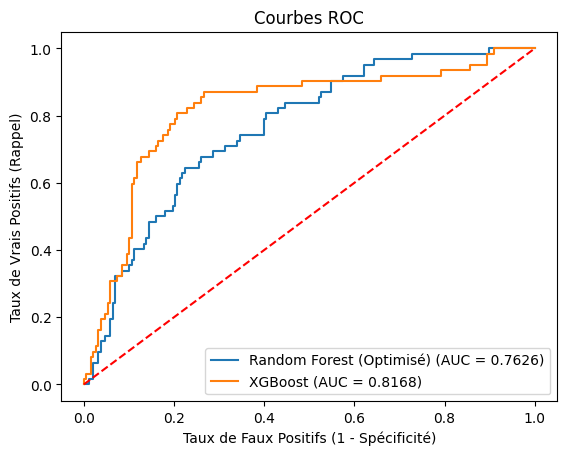

In [5]:
# ==========================================
# CELLULE 4 : MODÉLISATION ET ÉVALUATION
# ==========================================

# Dictionnaire pour stocker les résultats
results = {}

def evaluer_modele(model, nom):
    # Entraînement
    model.fit(X_train_scaled, y_train_smote)
    
    # Prédictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
    
    # Métriques
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n--- Évaluation du Modèle : {nom} ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {auc:.4f}")
    
    results[nom] = {'AUC': auc, 'Model': model, 'y_prob': y_prob, 'y_pred': y_pred}
    
    # Affichage de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{nom} (AUC = {auc:.4f})')
    return model

# --- 4.1 Modèle Random Forest (avec Grid Search) ---
print("Lancement de GridSearch pour Random Forest...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_best = evaluer_modele(rf_grid, "Random Forest (Optimisé)")

# --- 4.2 Modèle XGBoost ---
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_best = evaluer_modele(xgb_model, "XGBoost")

# --- Affichage final de la courbe ROC ---
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Rappel)')
plt.title('Courbes ROC')
plt.legend()
plt.show()

In [6]:
# ==========================================
# CELLULE 5 : ANALYSE COÛT-BÉNÉFICE
# ==========================================

# Définition des coûts hypothétiques (à ajuster selon le contexte commercial)
COST_FP = 1000  # Coût d'une enquête pour un Faux Positif (réclamation légitime enquêtée)
COST_FN = 10000 # Coût d'un Faux Négatif (argent perdu pour une fraude non détectée)

print("--- Analyse Coût Financier des Erreurs sur le Test Set ---")

for nom, res in results.items():
    tn, fp, fn, tp = confusion_matrix(y_test, res['y_pred']).ravel()
    
    cout_total = (fp * COST_FP) + (fn * COST_FN)
    rappel = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nModèle: {nom}")
    print(f"  Faux Positifs (FP): {fp}")
    print(f"  Faux Négatifs (FN): {fn}")
    print(f"  Rappel (Recall): {rappel:.4f}")
    print(f"  💰 Coût Total des Erreurs (sur 250 cas test): {cout_total:,.0f} $")

# Sauvegarder le meilleur modèle (celui avec le coût le plus bas ou le meilleur AUC)
best_model_name = max(results, key=lambda k: results[k]['AUC'])
best_model = results[best_model_name]['Model']
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"\n✅ Le meilleur modèle ({best_model_name}, basé sur l'AUC) a été sauvegardé au format .pkl.")

--- Analyse Coût Financier des Erreurs sur le Test Set ---

Modèle: Random Forest (Optimisé)
  Faux Positifs (FP): 15
  Faux Négatifs (FN): 42
  Rappel (Recall): 0.3226
  💰 Coût Total des Erreurs (sur 250 cas test): 435,000 $

Modèle: XGBoost
  Faux Positifs (FP): 20
  Faux Négatifs (FN): 26
  Rappel (Recall): 0.5806
  💰 Coût Total des Erreurs (sur 250 cas test): 280,000 $

✅ Le meilleur modèle (XGBoost, basé sur l'AUC) a été sauvegardé au format .pkl.



--- Calcul de l'analyse SHAP Globale ---


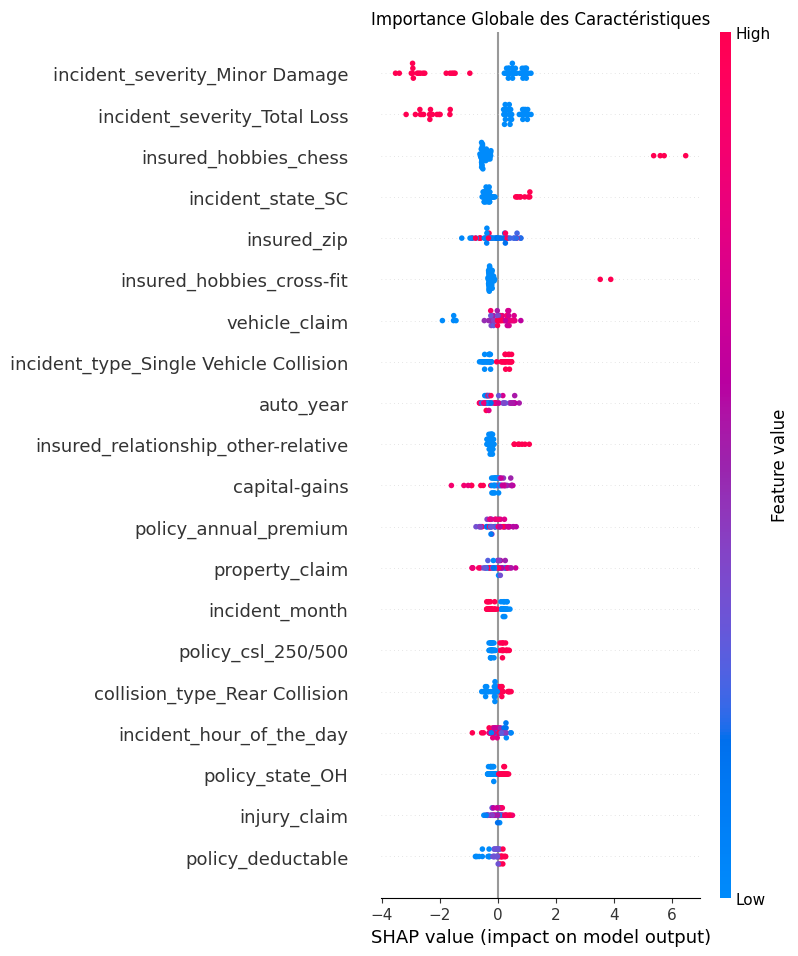


--- Analyse Locale (Force Plot) ---
Prédiction Locale pour l'index de test : 5
Vraie étiquette : 1 (1=Fraude, 0=Non)


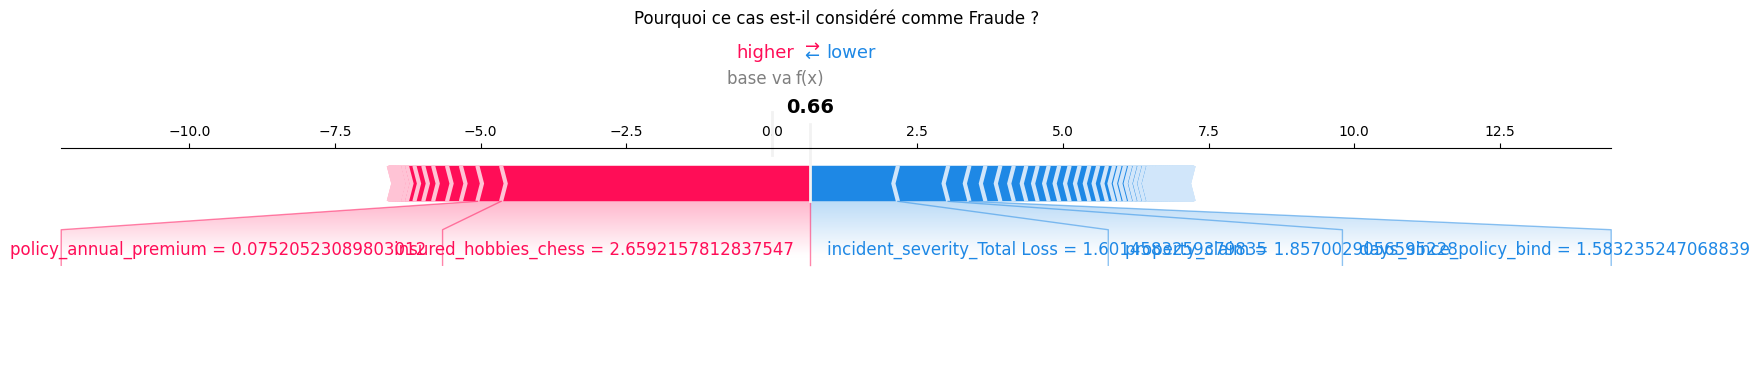

In [8]:
# ==========================================
# CELLULE 6 : INTERPRÉTABILITÉ (SHAP) - CORRIGÉE
# ==========================================

# On s'assure d'utiliser le meilleur modèle trouvé
rf_final = best_model 

# L'explainer SHAP
# Note : Si c'est XGBoost, TreeExplainer est très efficace
explainer = shap.TreeExplainer(rf_final)

# --- 1. Analyse Globale (Summary Plot) ---
print("\n--- Calcul de l'analyse SHAP Globale ---")
# On prend un petit échantillon du test set pour l'interprétabilité (50 à 100 max pour la rapidité)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
sample_idx = np.random.choice(X_test_df.index, size=50, replace=False)
X_sample = X_test_df.loc[sample_idx]

shap_values = explainer.shap_values(X_sample)

# Gestion du format de sortie (dépend si le modèle est Random Forest ou XGBoost)
if isinstance(shap_values, list):
    # Random Forest sort une liste [classe0, classe1]
    vals = shap_values[1] 
else:
    # XGBoost sort parfois directement array si binaire
    vals = shap_values

plt.figure(figsize=(10, 8))
shap.summary_plot(vals, X_sample, show=False)
plt.title("Importance Globale des Caractéristiques")
plt.show()

# --- 2. Interprétabilité Locale (Exemple d'un cas de Fraude) ---
print("\n--- Analyse Locale (Force Plot) ---")

# Trouver l'index d'un cas prédit comme "Fraude" (1)
predicted_fraud_indices = (results[best_model_name]['y_pred'] == 1).nonzero()[0]

if len(predicted_fraud_indices) > 0:
    fraud_case_index = predicted_fraud_indices[0] # On prend le premier cas trouvé
    
    # CORRECTION ICI : .reshape(1, -1) pour transformer (N,) en (1, N)
    X_case = X_test_scaled[fraud_case_index].reshape(1, -1)

    # Recalculer les valeurs SHAP pour ce cas spécifique
    shap_values_case = explainer.shap_values(X_case)

    # Préparation des données pour le plot
    # Si shap_values_case est une liste (RF), on prend l'élément 1. Sinon (XGB), on prend tout.
    if isinstance(shap_values_case, list):
        shap_val_single = shap_values_case[1][0] # [classe 1][ligne 0]
    else:
        shap_val_single = shap_values_case[0] # [ligne 0] (si XGBoost sort une matrice)

    # Affichage
    print(f"Prédiction Locale pour l'index de test : {fraud_case_index}")
    print(f"Vraie étiquette : {y_test.iloc[fraud_case_index]} (1=Fraude, 0=Non)")
    
    # Force Plot
    # Note : expected_value peut être une liste ou un float selon le modèle
    base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    
    shap.force_plot(
        base_value, 
        shap_val_single, 
        X_case[0], # On remet en 1D pour l'affichage
        feature_names=feature_names, 
        matplotlib=True, 
        show=False
    )
    plt.title(f"Pourquoi ce cas est-il considéré comme Fraude ?", y=1.5)
    plt.show()

else:
    print("Aucun cas de fraude n'a été prédit dans cet échantillon de test.")